# Imports

In [9]:
import base64
import json
import cv2
import time
import base64
from PIL import Image
from io import BytesIO
import numpy as np
import pyrealsense2 as rs
from pydantic import BaseModel
from typing import List
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
import matplotlib.pyplot as plt


# Prompt Templates

In [10]:
robot_template = """You are an object detector. If the object described in the prompt is in the 424 * 240 image, 
please return the top left and bottom right x and y coordinates of the object with the origin at the top left in a JSON format:
{
    "x1": <x-coordinate>, "y1": <y-coordinate>,
    "x2": <x-coordinate>, "y2": <y-coordinate>
}. 
Where x1 and y1 are the top left coordinates and x2 and y2 are the bottom right coordinates. Please do not include the string 'json' in the output.

Here is a question:
{input}"""

chat_template = """Respond to the given image. 
Here is a question:
{input}"""

prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about given images", 
        "prompt_template": chat_template
    },
    {
        "name": "math", 
        "description": "Good for producing task steps with the pixel coordinates for each step for the robot to grab onto", 
        "prompt_template": robot_template
    }
]

# Image capturing and handling

In [11]:
# Capture image using Intel RealSense
def captureimage():
    # Initialize RealSense pipeline
    pipe = rs.pipeline()
    cfg = rs.config()

    cfg.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 15)
    #cfg.enable_stream(rs.stream.depth, 424, 240, rs.format.z16, 6)


    # Start the pipeline
    profile = pipe.start(cfg)

     # Enable auto-exposure
    color_sensor = profile.get_device().query_sensors()[1]
    color_sensor.set_option(rs.option.enable_auto_exposure, 1)
    color_sensor.set_option(rs.option.enable_auto_white_balance, 1)
    #color_sensor.set_option(rs.option.white_balance, 3000)  # Adjust the value (e.g., 3000 to 6500)


    # Allow the camera to warm up
    for _ in range(5):
        pipe.wait_for_frames()
    # Align depth frame to color frame
    align_to = rs.stream.color
    align = rs.align(align_to)
    
    # Capture frames
    frames = pipe.wait_for_frames()
    aligned_frames = align.process(frames)
    color_frame = aligned_frames.get_color_frame()
    
    if not color_frame:
        print("Failed to capture frames.")
        return None

    # Convert images to numpy arrays
    color_image = np.asanyarray(color_frame.get_data())
    color_image = cv2.convertScaleAbs(color_image, alpha=1.8, beta=30)

    
    # Display the image using Matplotlib in Jupyter
    plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.axis('off')  
    plt.show()  
    
    image_data = getimagedata(color_image)
    return image_data

# Save the captured frame as an image
def save_image(color_image):
    file_path = "scene.jpg"
    cv2.imwrite(file_path, color_image)
    print("Image captured and saved successfully!")
    return file_path


# Convert the image to base64 encoded data
def getimagedata(color_image):
    image_path = save_image(color_image)
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()
    image_data = base64.b64encode(image_data).decode("utf-8")
    return image_data


# Setting up the AI model with LangChain

In [12]:
model = ChatOpenAI(model="gpt-4o", temperature=0.0)

In [13]:
# Description class for Pydantic
class Description(BaseModel):
    description: List[str] = None

parser = JsonOutputParser(pydantic_object=Description)

# Templates

In [14]:
# Create a prompt template for the system
system_template = """You are a multi purpose controller of a robotic arm that gives a string list of verbose description of targets 
for the robot to complete the given task.
A target is just where the robot arm should go to.
Please do not include any preamble; I just want the list.
If the task is hypotethically accomplished , return an empty string. 
If no object fits the objective return an empty string.
Do not include the JSON string within the response
In the JSON Format: ["description of object"]"""




# Create the prompt templates for the actions
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), 
     ("user", [
        {"type": "text", "text": "{user_prompt}"},
        {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}
     ])
    ]
)


# Action system template
action_system_template = """You are an object detector that is given an image of a 3*3 matrix. . 
If the object described in the prompt is in the image,
Then return the square of the 3*3 matrix the object is in. The matrix is numbered as follows:
1|2|3
4|5|6
7|8|9

If there are square that contains the object, return just one of the square.
A definite grid is provided in the image, if any object detected is not in the definite grid do not return it's grid number. 
Do not gridify the image but refer to the grid that is given in the image.
Give the number. Always give only the NUMBER."""

# Templates for various prompt chains
action_prompt_template = ChatPromptTemplate.from_messages(
    [("system", action_system_template), (
            "user",
            [   {"type": "text", "text": "{description}"},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}
            ]
        ),
    ]
)

determine_system_template = """You are the last process in a pipeline of a robotic controller that accompolishes a task given by a user.
You do not have to do anything, just determine if the task is hypothetically accomplished.
I dont need advice.
If the target object from the task is not present in the image, assume task is accomplished.
If you determine that the task is accompolished respond with 1.
If you determine that the task has not been accompolished respond with 0.
give the response first, then explain why. always give the number first.

""" 

determine_prompt_template = ChatPromptTemplate.from_messages(
    [("system", determine_system_template), (
            "user",
            [   {"type": "text", "text": "{user_prompt}"},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}
            ]
        ),
    ]
)

chat_system_template = """You are an object detector. You are to answer any questions based on the image provided to you."""

chat_prompt_template = ChatPromptTemplate.from_messages(
    [("system", chat_system_template), (
            "user",
            [   {"type": "text", "text": "{user_prompt}"},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}
            ]
        ),
    ]
)
#If you determine that the user input is asking you to play a game, respond with a 2.
intent_system_template = """You are an intent detector. Just give the hypothetical intent based on the prompt given.

If you determine that the user input requires you to carry out a task, respond with a 1.
If you determine that the user input is asking a general question or asking for the presence of something, respond with a 0.
give the response and explain why. Give the response before you explain.
""" 

intent_prompt_template = ChatPromptTemplate.from_messages(
    [("system", intent_system_template), (
            "user",
            [   {"type": "text", "text": "{user_prompt}"}
            ]
        ),
    ]
)


# Chains Setup

In [15]:
chain = prompt_template | model
action_chain = action_prompt_template | model
determine_chain = determine_prompt_template | model
intent_chain = intent_prompt_template | model
chat_chain = chat_prompt_template | model


# Main interaction logic

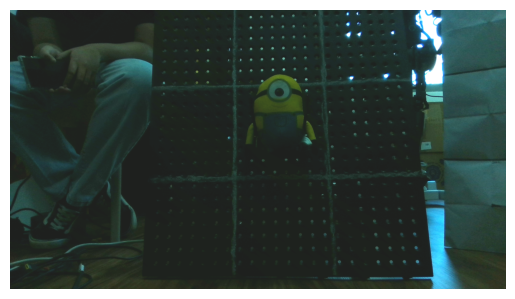

Image captured and saved successfully!

Intent Response:  0

The prompt is asking a general question about what is visible or present, rather than requesting a specific task to be carried out.

Chat Response:  The image shows a small toy figure resembling a Minion from the "Despicable Me" series, attached to a perforated board. There is a person sitting on the left side, holding something in their hands, and some cables on the floor.


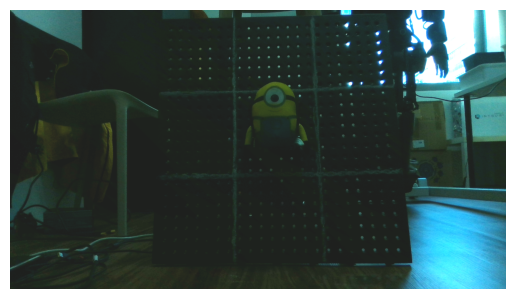

Image captured and saved successfully!

Intent Response:  1

The intent is to carry out a task, which is to remove the yellow minion.
chain Response: ["yellow minion toy attached to the black perforated board"]
<class 'list'>
['yellow minion toy attached to the black perforated board']
MOVING NOW: 5


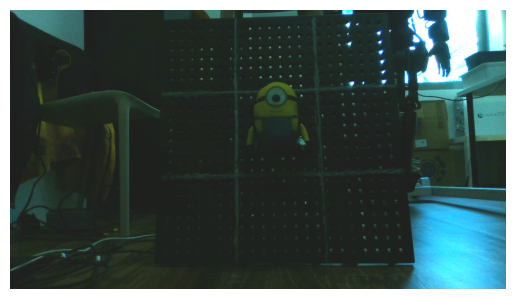

Image captured and saved successfully!
new flag 0

The yellow minion is still present in the image.
chain Response: ["yellow minion toy on the black perforated board"]
<class 'list'>
['yellow minion toy on the black perforated board']
MOVING NOW: 5


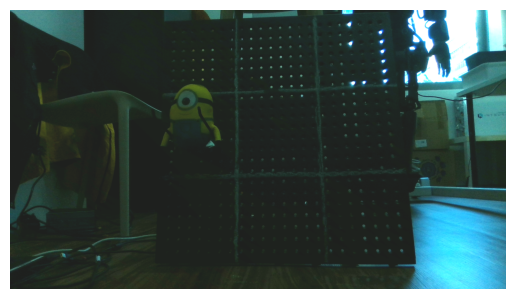

Image captured and saved successfully!
new flag 0

The yellow minion is still present in the image.
chain Response: ["yellow minion toy on the left side of the black perforated board"]
<class 'list'>
['yellow minion toy on the left side of the black perforated board']
MOVING NOW: 4


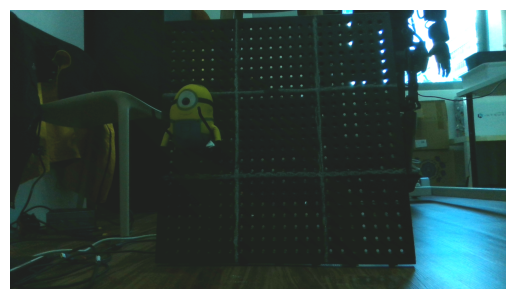

Image captured and saved successfully!
new flag 0

The yellow minion is still present in the image.
chain Response: ["yellow minion toy on the black perforated board"]
<class 'list'>
['yellow minion toy on the black perforated board']
MOVING NOW: 4


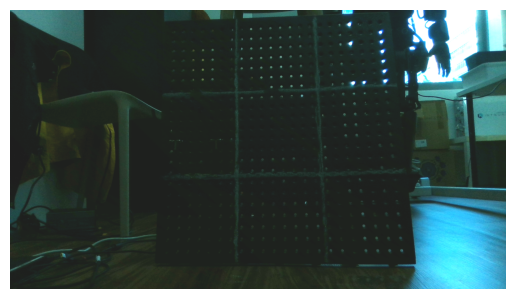

Image captured and saved successfully!
new flag 1

The yellow minion is not present in the image.


In [16]:
def run_interaction_loop():
    while True:
        user_prompt = input("Please type something (enter Q to quit): ")
        if user_prompt == "Q":
            break
        image_data = captureimage()
        intent_response = intent_chain.invoke({"user_prompt": user_prompt})
        intent_flag = intent_response.content[0]
        print("\nIntent Response: ", intent_response.content)

        if int(intent_flag) == 0:    
            chat_response = chat_chain.invoke({"user_prompt": user_prompt, "image_data": image_data })
            print("\nChat Response: ", chat_response.content)
        
        if int(intent_flag) == 1:        
            loop_flag = 0
            while int(loop_flag) == 0:
                response = chain.invoke({"user_prompt": user_prompt, "image_data": image_data })
                print("chain Response:",response.content)
                parsed_output = parser.parse(response.content)
            
                print(type(parsed_output))
                print(parsed_output)
                objectIn = action_chain.invoke({"description":parsed_output[0],"image_data": image_data})
                print("MOVING NOW:", objectIn.content)

                time.sleep(7)
                image_data = captureimage()
                new_determine_flag = determine_chain.invoke({"user_prompt": user_prompt, "image_data": image_data })
                print("new flag",new_determine_flag.content)
                loop_flag = new_determine_flag.content[0] 
        
        

run_interaction_loop()